<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.3
# *KNN classification Lab*

**In this lab, we will:**
- Practice KNN classification on a dataset of breast cancer.
- Predict the `diagnosis` of a patient from predictor variables of your choice.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from scipy import stats
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [55]:
# Load dataset
breast_cancer_csv = '../../DATA/breast-cancer-wisconsin-data.csv'
breast_cancer = pd.read_csv(breast_cancer_csv, index_col='id')

### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [56]:
# Head
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [57]:
# Shape
breast_cancer.shape

(569, 32)

In [58]:
# Descriptive statistics
breast_cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [59]:
# Df summary
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [60]:
# Missing values
breast_cancer.isna().sum().sum()

569

In [61]:
# Remove feature w/ NaNs
breast_cancer.drop(labels='Unnamed: 32', axis=1, inplace=True)

In [62]:
# Missing values
breast_cancer.isna().sum().sum()

0

In [63]:
# Replace white spaces w/ _
breast_cancer.columns = breast_cancer.columns.str.replace(' ', '_')

In [64]:
# Percentage diagnosis values
breast_cancer['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [65]:
# Map diagnosis values: benign to 0 and malignant to 1
bm_map = {'B': 0, 'M': 1}

breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map(bm_map)

In [66]:
# dtype of diagnosis?
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave_points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

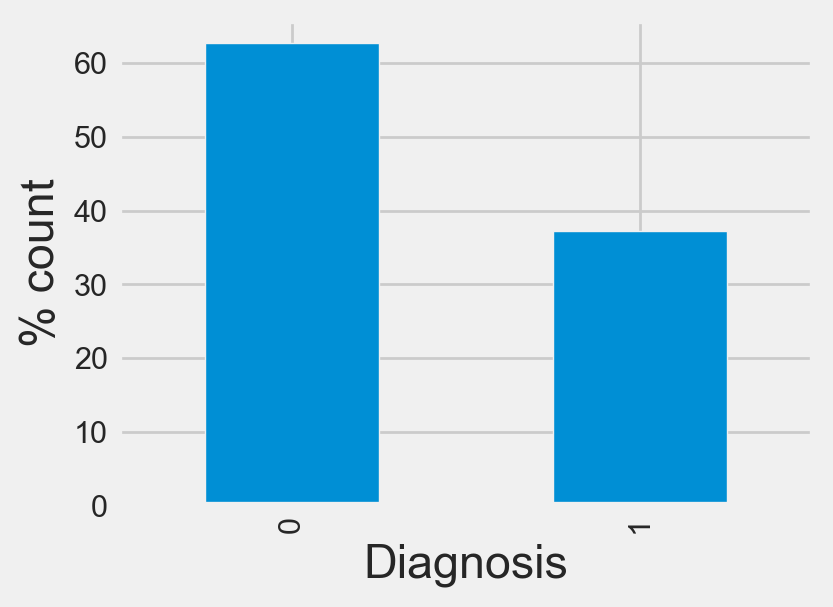

In [67]:
# Plot % of diagnosis values
plt.figure(figsize=(4,3))
(breast_cancer['diagnosis'].value_counts(normalize=True)*100).plot(kind='bar')
plt.ylabel('% count')
plt.xlabel('Diagnosis');

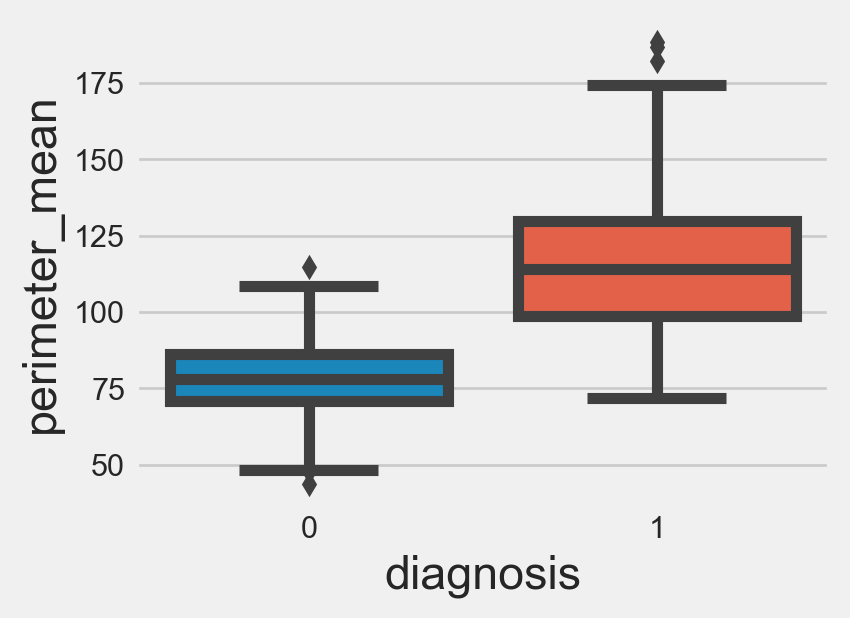

In [68]:
# Compare distribution of perimeter_mean between B and M groups
plt.figure(figsize=(4,3))
sns.boxplot(x='diagnosis', y='perimeter_mean', data=breast_cancer);

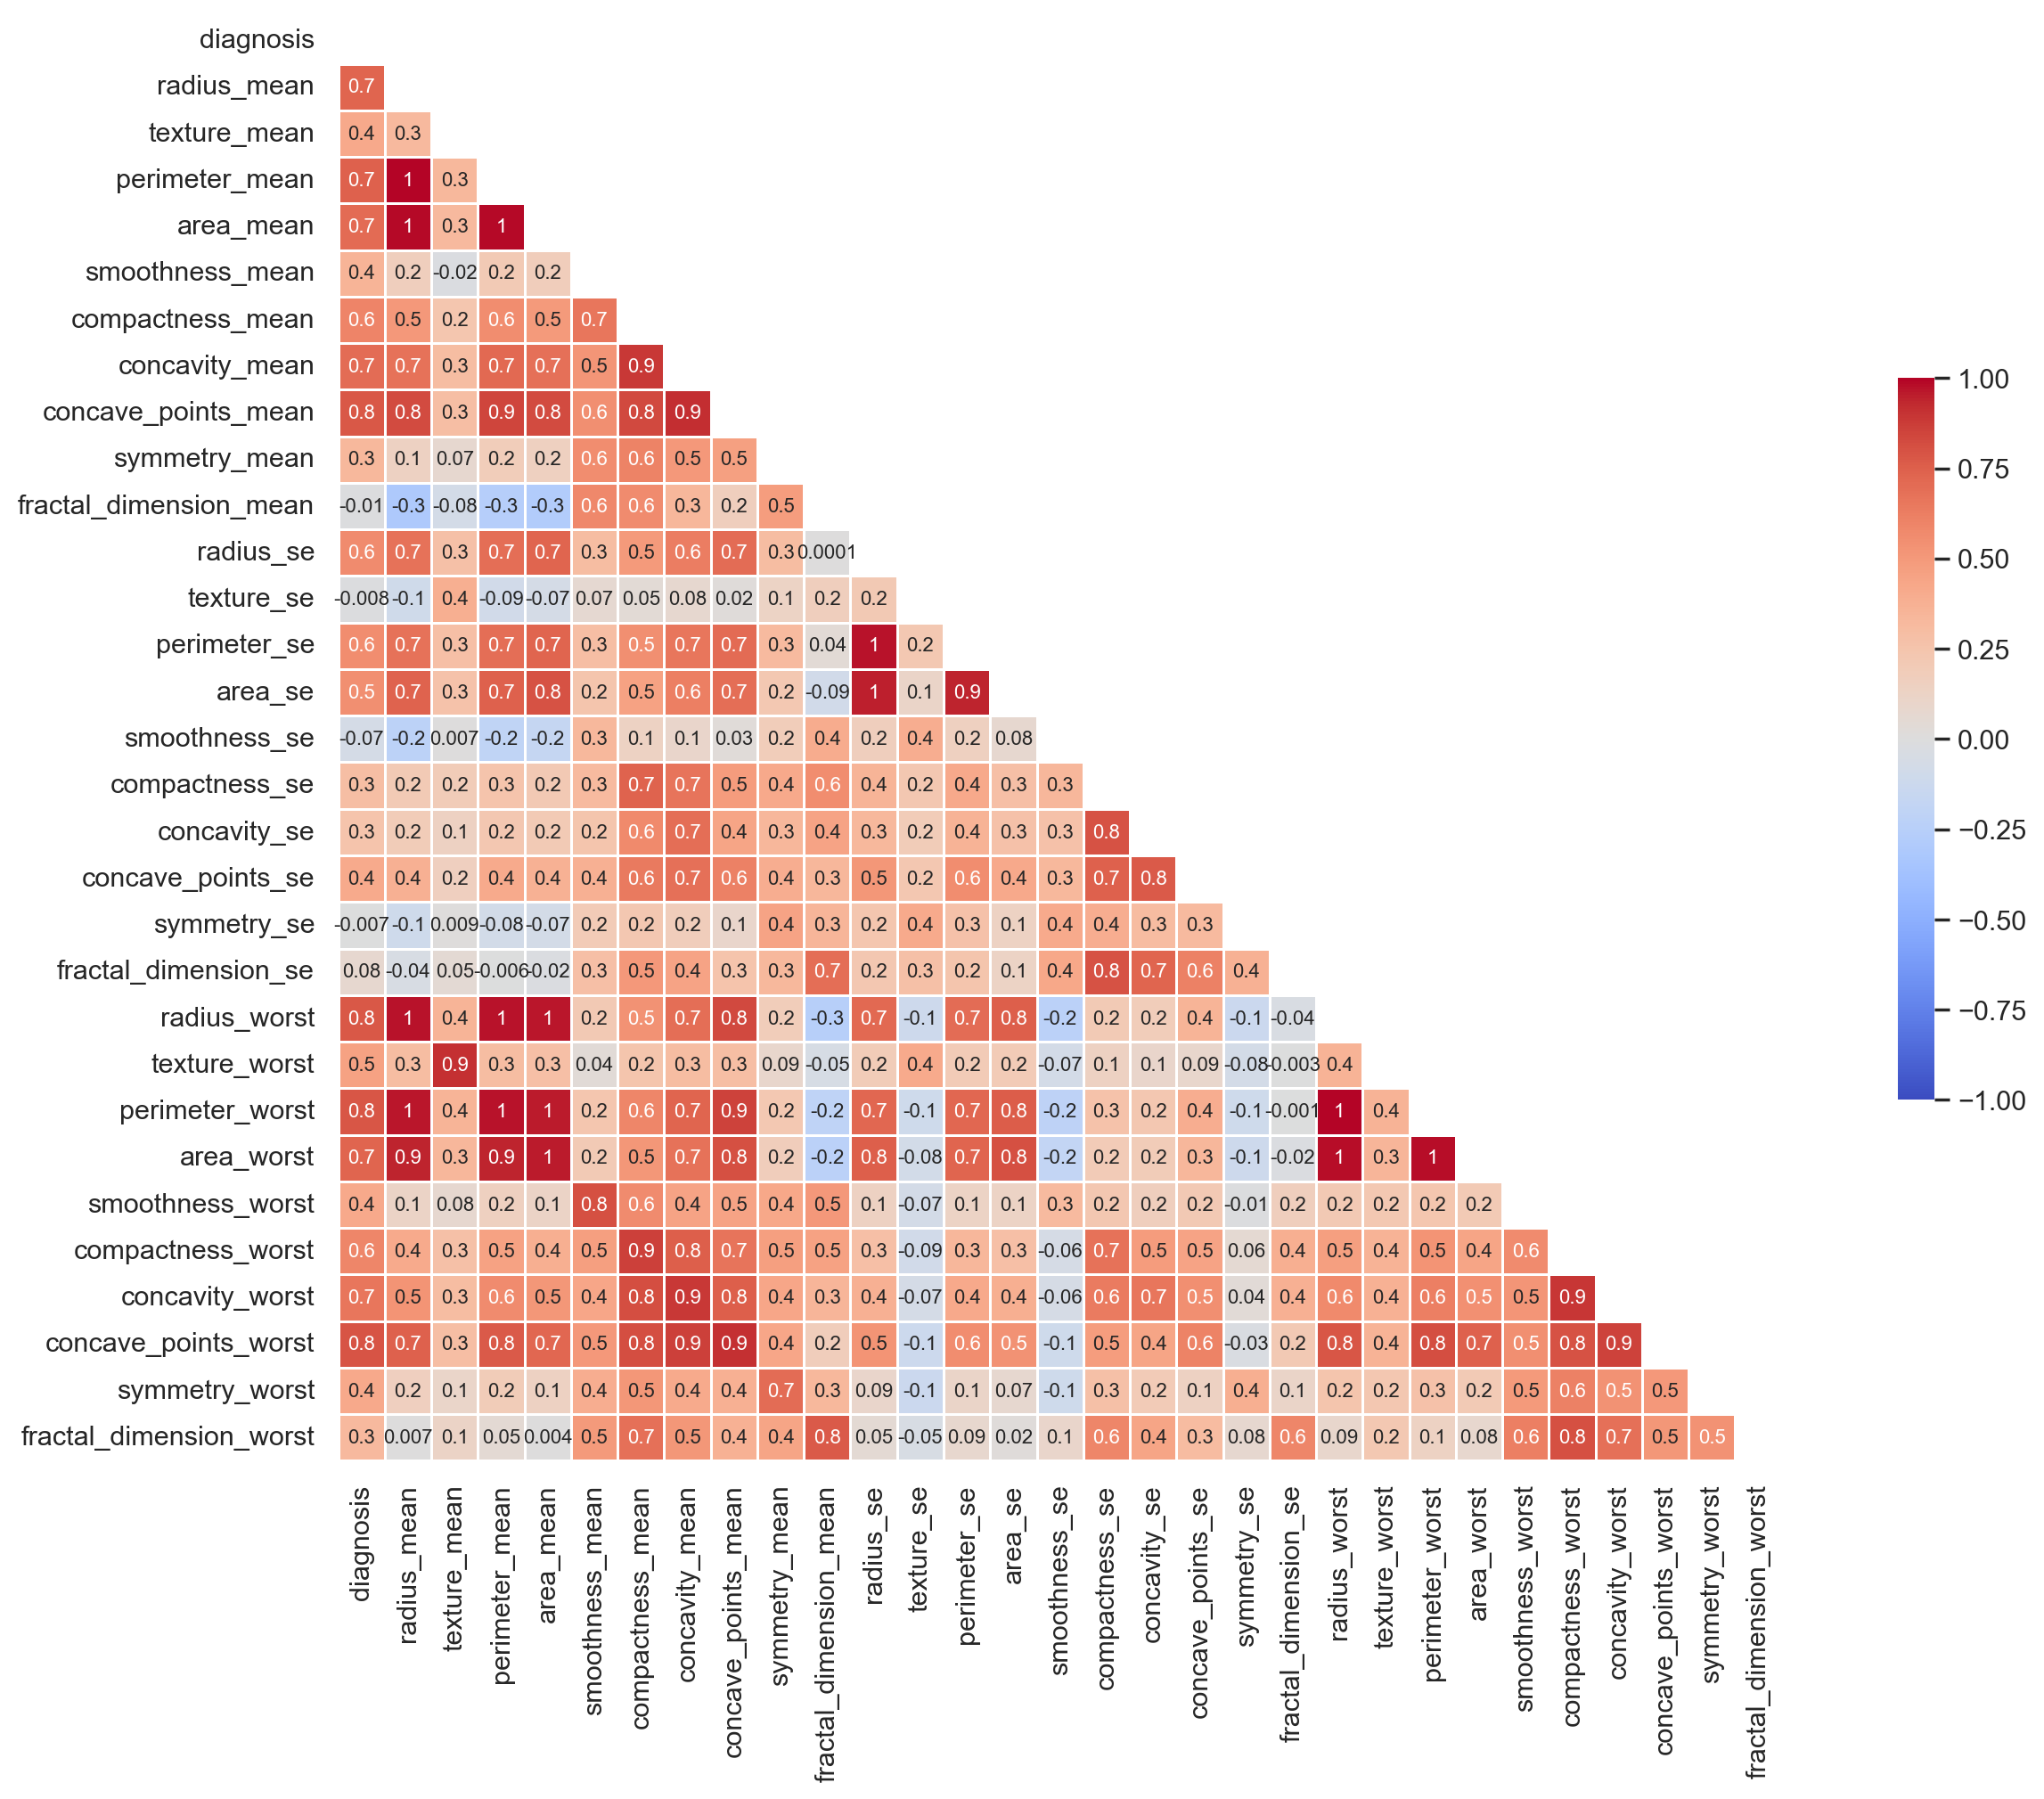

In [69]:
# Correlation heatmap
sns.set_theme(style="white")
plt.figure(figsize=(15,10))

# Generate mask for upper triangle
mask = np.zeros_like(breast_cancer.corr(), dtype=bool) #generate mask of "0's"
mask[np.triu_indices_from(mask)] = True #return upper triangle
# Set diverging colormap
cmap = sns.color_palette('coolwarm', as_cmap=True)
# Draw heatmap with mask and correct aspect ratio
sns.heatmap(breast_cancer.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, fmt='.1g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 8}, annot=True);

In [70]:
# What are the column names in the breast cancer csv?
breast_cancer.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [71]:
# Get columns that have 'mean' or 'diagnosis' in their names
mean_only_columns = []

for column in breast_cancer.columns:
    if '_mean' in column or 'diagnosis' in column:
        mean_only_columns.append(column)
        
# List comprehension version: 
# mean_only_columns = [c for c in breast_cancer.columns if not '_worst' in c and not '_se' in c]

print(mean_only_columns)

['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean']


In [72]:
# Select mean_only_columns in breast cancer dataframe
selected_breast_cancer = breast_cancer[mean_only_columns]
selected_breast_cancer.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean
id,,,,,,,,,,,
842302,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
842517,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667


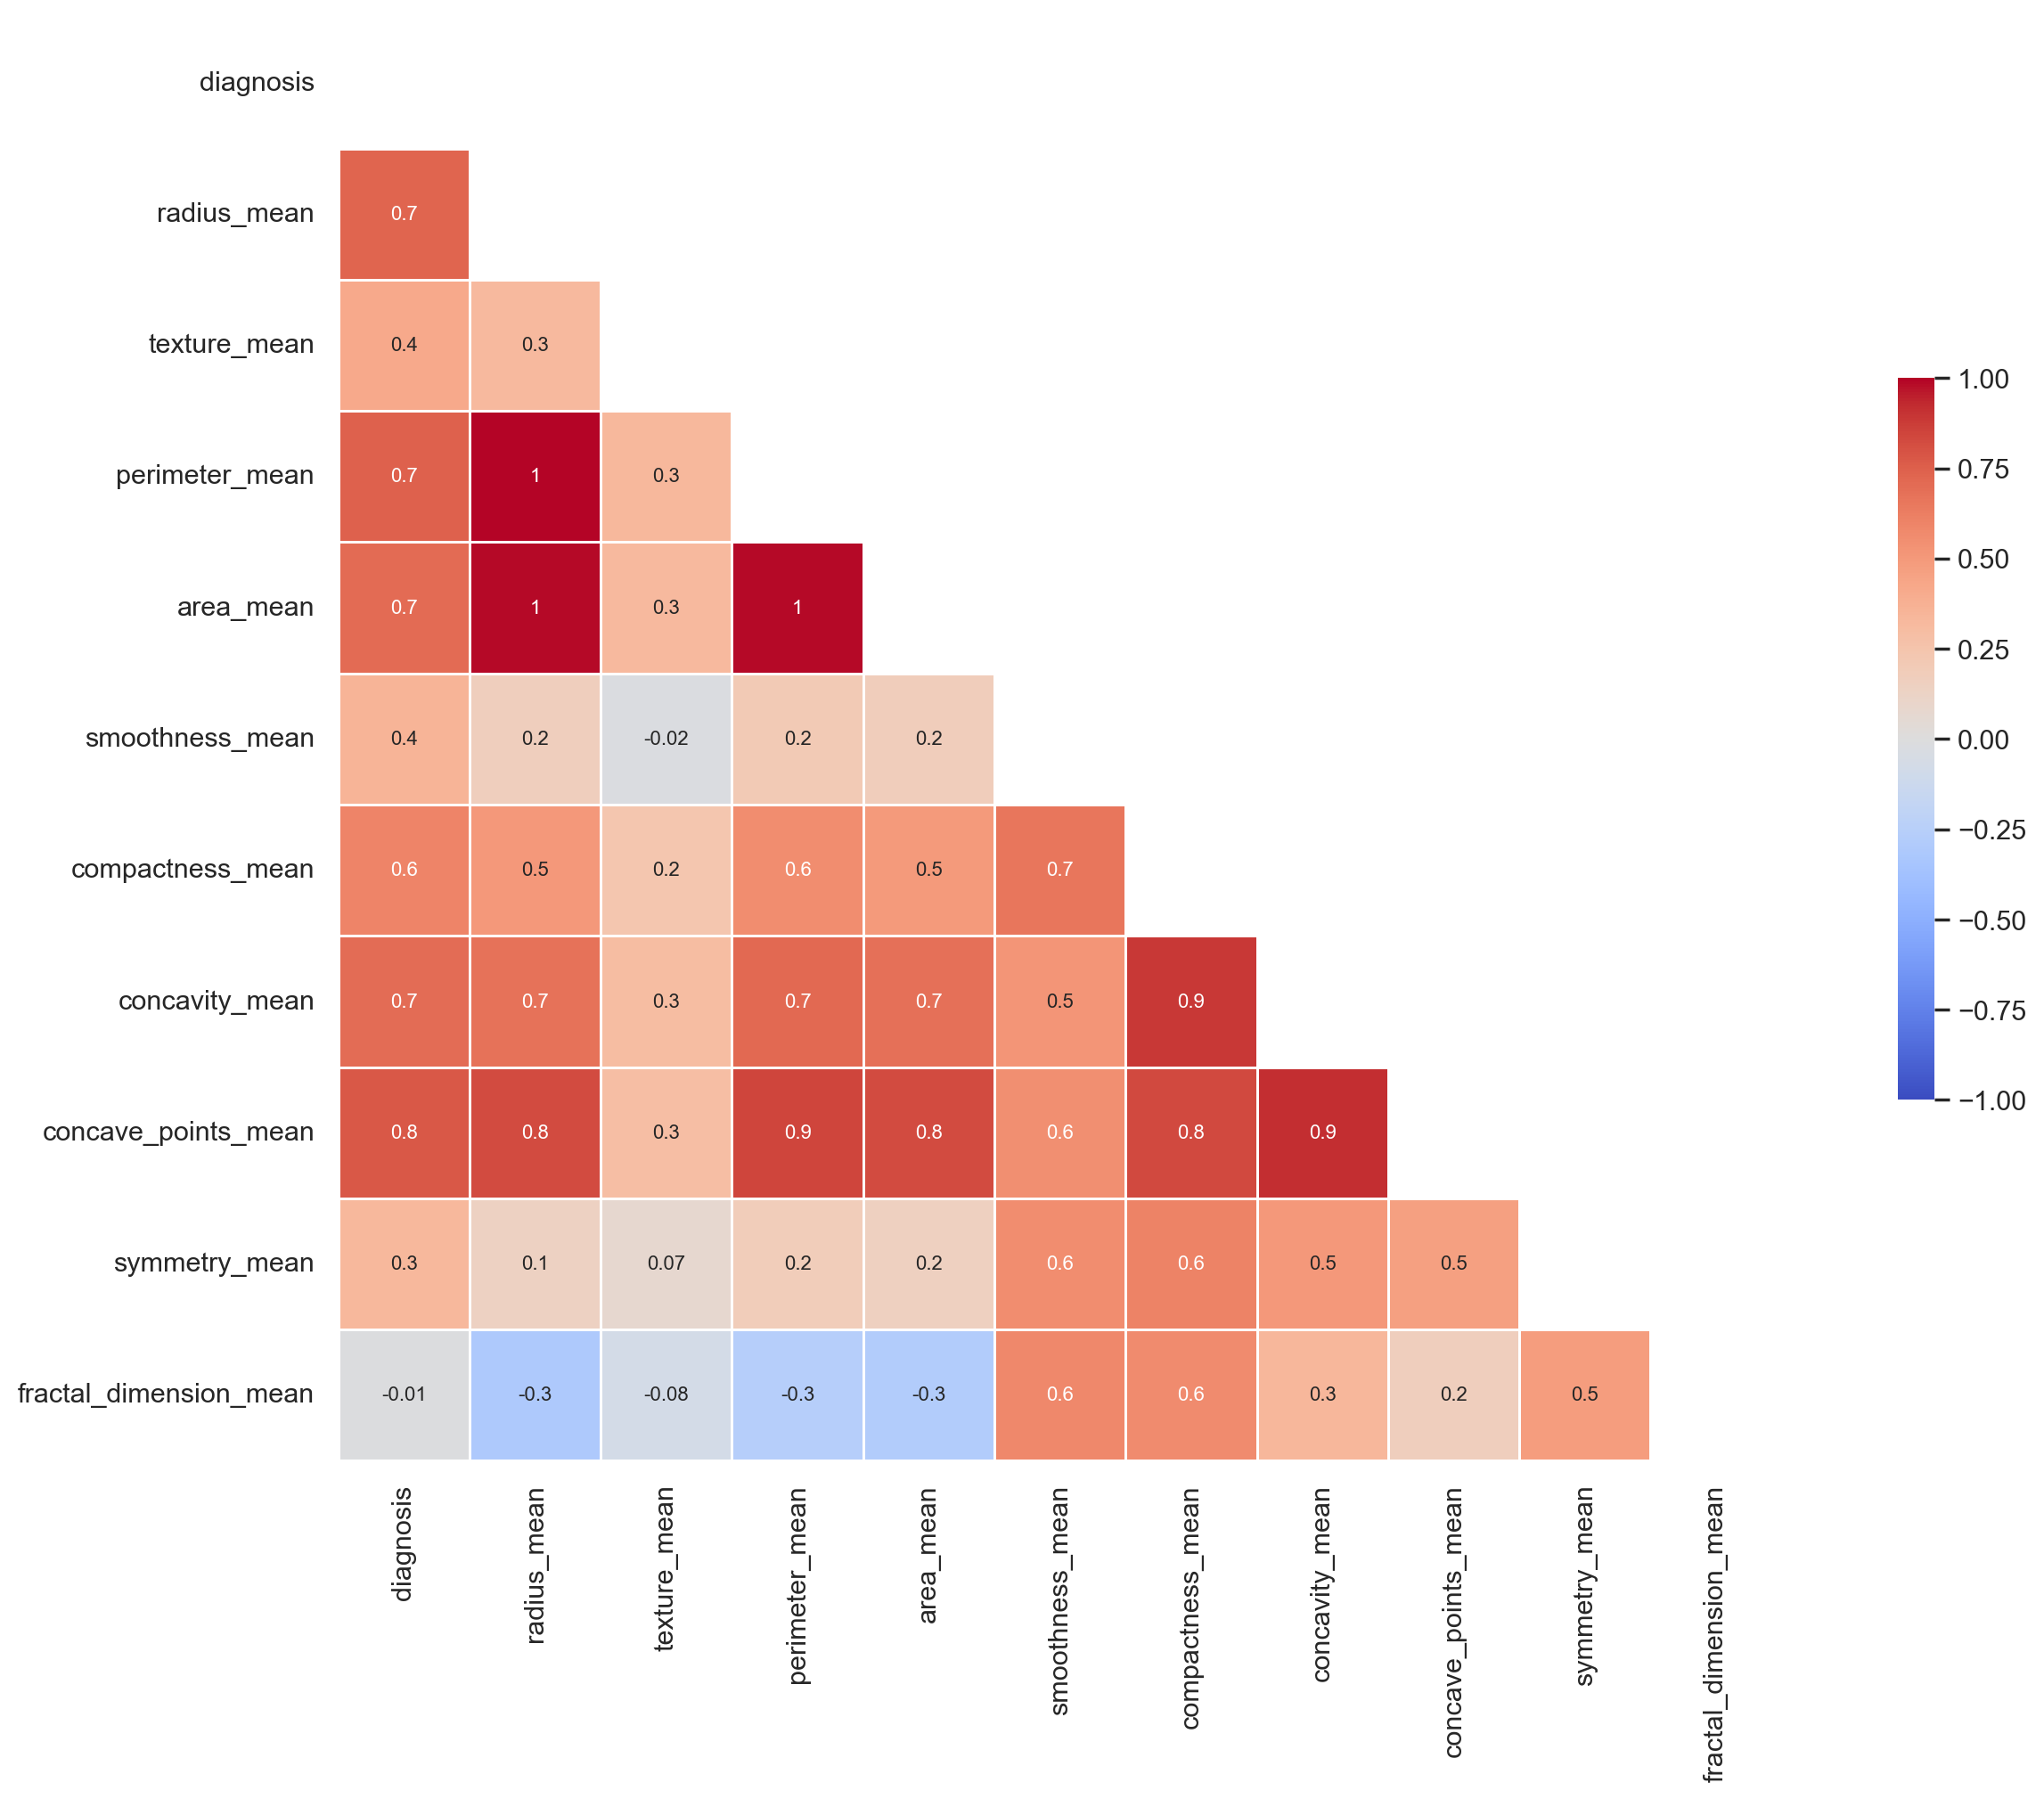

In [73]:
# Correlation heatmap
sns.set_theme(style="white")
plt.figure(figsize=(15,10))

# Generate mask for upper triangle
mask = np.zeros_like(selected_breast_cancer.corr(), dtype=bool) #generate mask of "0's"
mask[np.triu_indices_from(mask)] = True #return upper triangle
# Set diverging colormap
cmap = sns.color_palette('coolwarm', as_cmap=True)
# Draw heatmap with mask and correct aspect ratio
sns.heatmap(selected_breast_cancer.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, fmt='.1g',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 8}, annot=True);

In [74]:
def find_feature_correlations(df):
    """
    Find correlations between df features and convert to a format 
    with one feature1 vs. feature2 correlation value per row 
    
    _Params:_
    
    df: pandas DataFrame, features as columns. All datatypes must be numeric
    
    Returns a pandas DataFrame where a row contains one feature1 vs. feature2 correlation value
    """
    
    # initalise variable lists 
    var1 = []
    var2 = []
    pearsons = []
    pvalues = []
    
    # iterate over generator for tuples of feature combination pairs
    for comb in combinations(df.columns.tolist(), 2):
        var1.append(comb[0]) # save feature 1 to list 
        var2.append(comb[1]) # save feature 2 to list
        
        p, p_value = stats.pearsonr(df[comb[0]], df[comb[1]]) # get pearson correlation
        pearsons.append(p), pvalues.append(p_value)
    
    # Build dataframe of feature1 vs. feature2 pearson correlation
    corr_df = pd.DataFrame({'Feature1': var1,
                            'Feature2': var2,
                            'P': pearsons,
                            'p-value': pvalues})
    
    return corr_df

In [75]:
list(combinations(selected_breast_cancer.columns.tolist(), 2))[:10]

[('diagnosis', 'radius_mean'),
 ('diagnosis', 'texture_mean'),
 ('diagnosis', 'perimeter_mean'),
 ('diagnosis', 'area_mean'),
 ('diagnosis', 'smoothness_mean'),
 ('diagnosis', 'compactness_mean'),
 ('diagnosis', 'concavity_mean'),
 ('diagnosis', 'concave_points_mean'),
 ('diagnosis', 'symmetry_mean'),
 ('diagnosis', 'fractal_dimension_mean')]

In [76]:
# Use custom function to calculate correlations
cancer_corr = find_feature_correlations(selected_breast_cancer.select_dtypes(np.number))
cancer_corr.head()


,Feature1,Feature2,P,p-value
0,diagnosis,radius_mean,0.730029,8.465941e-96
1,diagnosis,texture_mean,0.415185,4.058636e-25
2,diagnosis,perimeter_mean,0.742636,8.436251e-101
3,diagnosis,area_mean,0.708984,4.734564e-88
4,diagnosis,smoothness_mean,0.358560,1.051850e-18


In [77]:
# Sort rows by descending values of Pearson correlation P 
cancer_corr[cancer_corr['P'] > 0.7]

,Feature1,Feature2,P,p-value
0,diagnosis,radius_mean,0.730029,8.465941e-96
2,diagnosis,perimeter_mean,0.742636,8.436251e-101
3,diagnosis,area_mean,0.708984,4.734564e-88
7,diagnosis,concave_points_mean,0.776614,7.101150e-116
11,radius_mean,perimeter_mean,0.997855,0.000000e+00
12,radius_mean,area_mean,0.987357,0.000000e+00
16,radius_mean,concave_points_mean,0.822529,4.350747e-141
27,perimeter_mean,area_mean,0.986507,0.000000e+00
30,perimeter_mean,concavity_mean,0.716136,1.322967e-90
31,perimeter_mean,concave_points_mean,0.850977,1.047656e-160


### 3. Set up the `diagnosis` variable as your target. How many classes are there?

In [78]:
# ANSWER
# Define target
y = breast_cancer['diagnosis']

* Target variable has 2 classes (0, 1)

### 4. What is the baseline accuracy?

In [79]:
# ANSWER
# What is the frequency of the most abundant class?
y.value_counts(normalize=True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

* 63% class 0 (benign)

### 5. Choose features to be your predictor variables and set up your X.

In [80]:
# ANSWER
# Choose features by column name
feature_columns = []
excluded_columns = ['diagnosis', 'area_mean', 'radius_mean', 'concavity_mean', 'compact_points_mean']

for column in selected_breast_cancer.columns:
    if column not in excluded_columns:
        feature_columns.append(column)

# list comprehension version:
# feature_columns = [c for c in selected_breast_cancer.columns if c not in excluded_columns]

# Filter for the feature columns
X = selected_breast_cancer[feature_columns]
X.head()

,texture_mean,perimeter_mean,smoothness_mean,compactness_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean
id,,,,,,,
842302,10.38,122.80,0.11840,0.27760,0.14710,0.2419,0.07871
842517,17.77,132.90,0.08474,0.07864,0.07017,0.1812,0.05667
84300903,21.25,130.00,0.10960,0.15990,0.12790,0.2069,0.05999
84348301,20.38,77.58,0.14250,0.28390,0.10520,0.2597,0.09744
84358402,14.34,135.10,0.10030,0.13280,0.10430,0.1809,0.05883


### 6. Fit a `KNeighborsClassifier` with 1 neighbor using the target and predictors.

In [81]:
# ANSWER
# Instantiate KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# Fit on UNSTANDARDIZED data:
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

### 7. Evaluate the accuracy of your model.
- Is it better than baseline?
- Is it legitimate?

In [82]:
# ANSWER
# Predict response values for the observations in X ("test the model") and store predicted response values
y_pred_class = knn.predict(X)

# Compute classification accuracy
print(metrics.accuracy_score(y, y_pred_class))

1.0


### 8. Create a 80-20 train-test-split of your target and predictors. Refit the KNN and assess the accuracy.

In [83]:
# ANSWER
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print(f"Accuracy test score: {metrics.accuracy_score(y_test, y_pred_class):.2f}")

Accuracy test score: 0.94


In [84]:
metrics.confusion_matrix(y_pred_class, y_test)

array([[65,  1],
       [ 6, 42]], dtype=int64)

### 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data.

In [85]:
# To quickly get a value for 'optimal' k, sqrt of number of samples
np.sqrt(X_train.shape[0])

21.330729007701542

In [86]:
X_train.shape

(455, 7)

In [87]:
# ANSWER
# Create an instance of KNeighborsClassifier where n_neighbors = number of rows in the training data
k = X_train.shape[0]

# Fit Train Data
knn = KNeighborsClassifier(n_neighbors=k) # here k=455
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

# Print accuracy_score
print(f"Accuracy test score: {metrics.accuracy_score(y_test, y_pred_class):.2f}")

Accuracy test score: 0.62


### 10. Fit the KNN at values of K from 1 to the number of rows in the training data.
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

In [88]:
# ANSWER
list(range(1, X_train.shape[0]+1))[-5:]

[451, 452, 453, 454, 455]

In [89]:
# Get accuracy of models with increasing number of neighbors
test_acc = []

for i in range(1, X_train.shape[0]+1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    test_acc.append(knn.score(X_test, y_test))

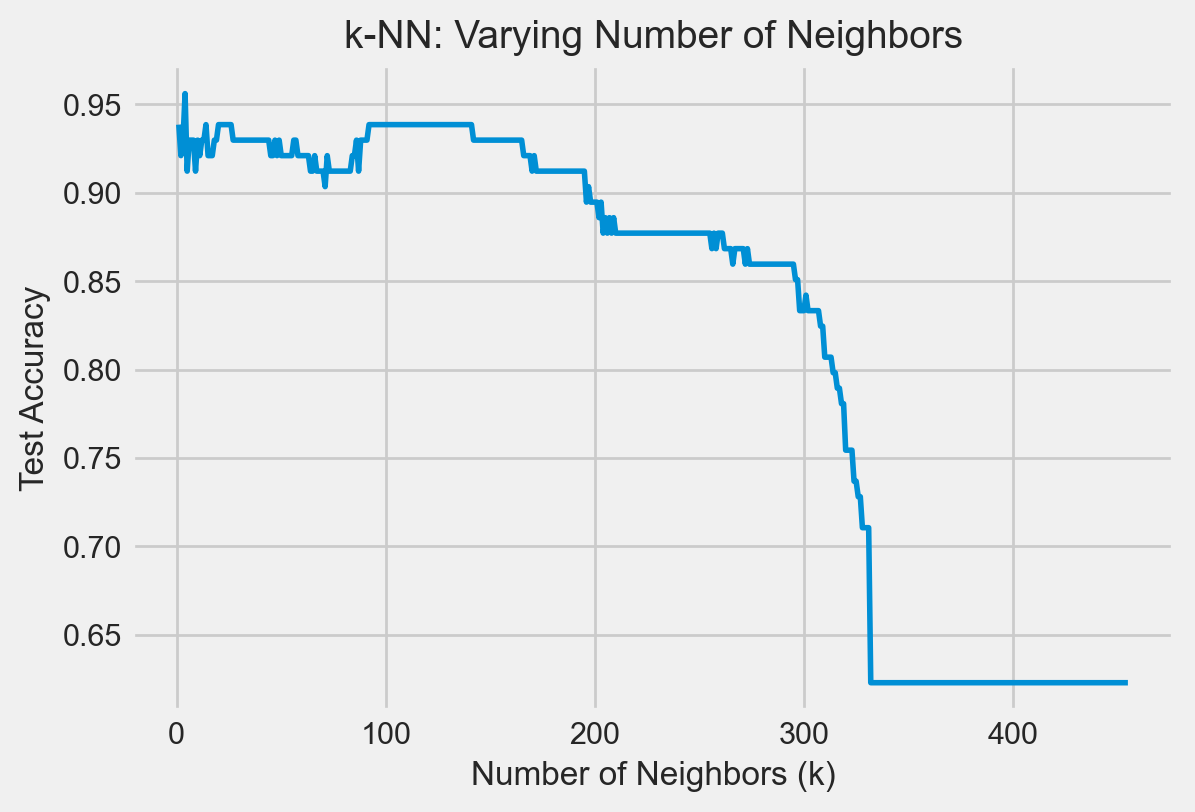

In [90]:
# Plot test accuracy by number of neighbors:  
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(list(range(1, X_train.shape[0]+1)), test_acc, lw=2)
ax.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
plt.title('k-NN: Varying Number of Neighbors', fontsize=14);

### 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds.


In [91]:
# ANSWER
max_neighbors = np.floor(X.shape[0] - X.shape[0]/5)
print(max_neighbors)

455.0


In [92]:
X.shape[0], X.shape[0]/5

(569, 113.8)

In [93]:
X.shape[0] - X.shape[0]/5

455.2

In [94]:
knn = KNeighborsClassifier(n_neighbors=5)
cross_val_score(knn, X, y, cv=5)

array([0.87719298, 0.85964912, 0.9122807 , 0.9122807 , 0.91150442])

In [95]:
%%time

## Cross validation
# Calculate test accuracy for model fitted with increasing number of neighbors:
folds = 5
test_acc_mean = []

for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc_mean.append(np.mean(cross_val_score(knn, X, y, cv=folds)))

Wall time: 38.7 s


In [96]:
test_acc_mean[:3], test_acc_mean[-3:]

([0.8682192206179165, 0.8928737773637634, 0.8875640428504891],
 [0.6274181027790716, 0.6274181027790716, 0.6274181027790716])

In [97]:
print(f"Best test accuracy: {max(test_acc_mean):.2f}")

Best test accuracy: 0.91


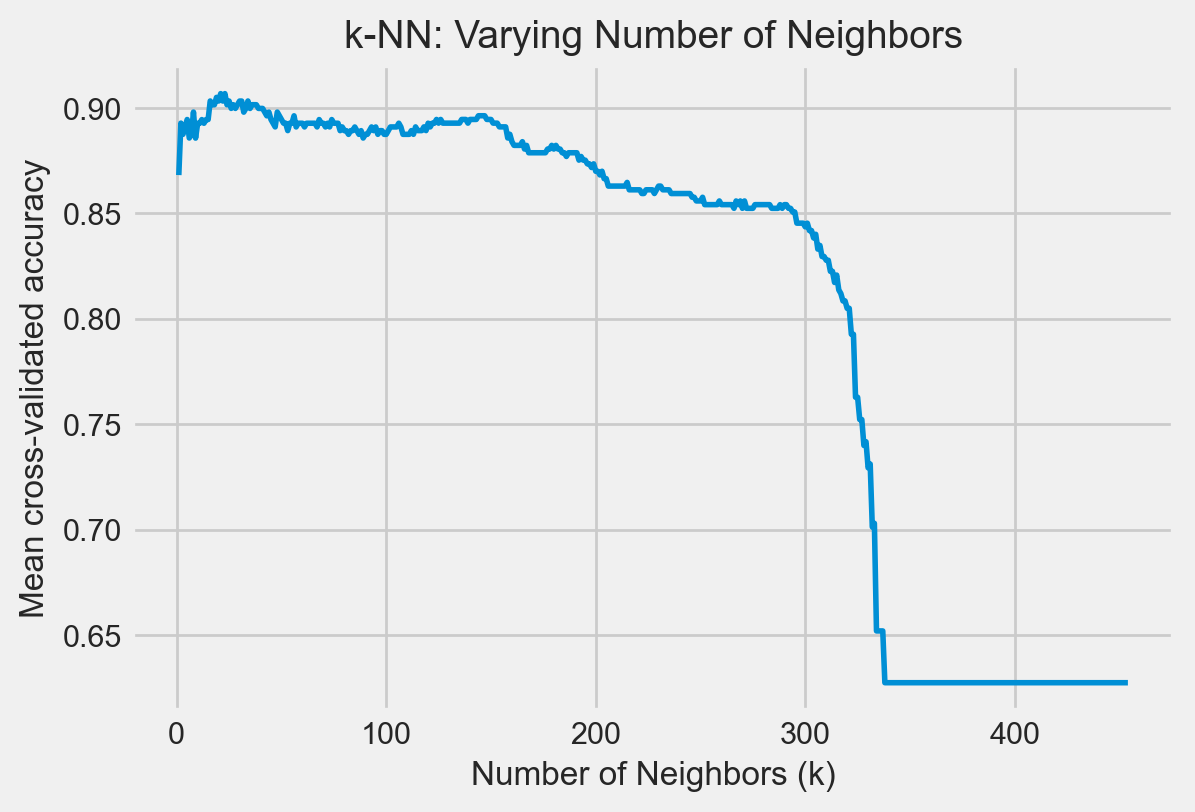

In [98]:
# Plot the accuracy vs. neighbours in KNN model
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(list(range(1, int(max_neighbors))), test_acc_mean, lw=2)
ax.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax.set_ylabel('Mean cross-validated accuracy', fontsize=12)
plt.title('k-NN: Varying Number of Neighbors', fontsize=14);

### 12. Standardize the predictor matrix and cross-validate across the different K.
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [99]:
# ANSWER
# Standarize X
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [100]:
%%time

## Cross validation
# Calculate test accuracy for model fitted with increasing number of neighbors:
folds = 5
test_acc_mean_std = []

for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc_mean_std.append(np.mean(cross_val_score(knn, Xs, y, cv=5)))

Wall time: 33.5 s


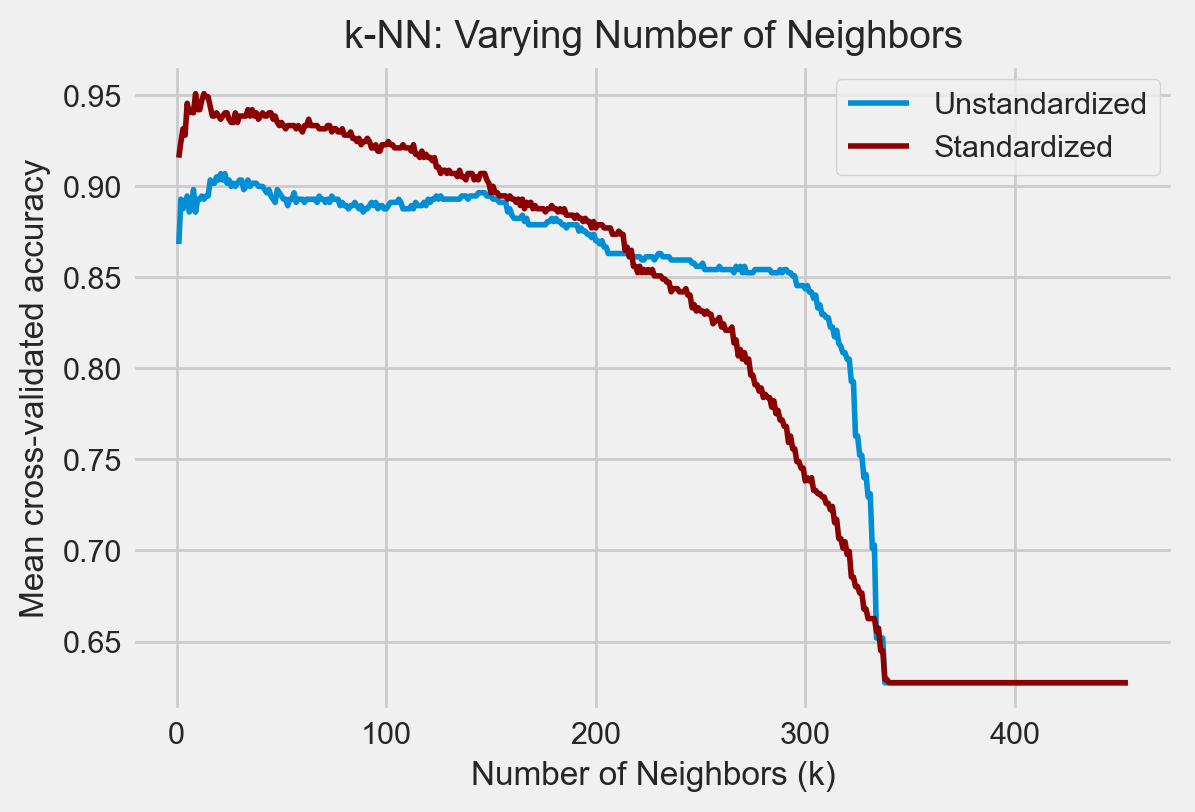

In [101]:
# ANSWER
# Plot the accuracy vs. neighbours in KNN model
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(list(range(1, int(max_neighbors))), test_acc_mean, lw=2, label='Unstandardized')
ax.plot(list(range(1, int(max_neighbors))), test_acc_mean_std, lw=2, label='Standardized', color='darkred')
ax.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax.set_ylabel('Mean cross-validated accuracy', fontsize=12)
plt.title('k-NN: Varying Number of Neighbors', fontsize=14)
plt.legend();

## Bonus

## Cross-Validation with GridSearchCV

In [102]:
%%time

# Perform cross-validation with GridSearchCV
param_grid = {'n_neighbors':np.arange(1,51)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5) # test cv=3, 5, 10
knn_cv.fit(Xs, y)

print(f"Best Score: {knn_cv.best_score_:.2f}")
print(f"Best Parameters: {knn_cv.best_params_}")

Best Score: 0.95
Best Parameters: {'n_neighbors': 9}
Wall time: 1.52 s


**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



